# Detectando e Interpretando Sinais Periódicos em Séries Temporais Paleobiológicas
Exercício-Programa da disciplina CCM0228 - Computação IV, 2025.1, dos alunos:
- `Aluno 1`: Helena Baptista Reis
- `NUSP`: 14577622
- `Aluno 2`: Luca Marinho Nasser Valadares Paiva
- `NUSP`: 13691375

In [52]:
# Dependências
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.fft import fft, fftfreq

# Paths
GENERA_DATA_PATH = Path("data/raw/genera_data.csv")
RESULTS_PATH = Path("data/processed/")

## Índice
- Etapa 1 - Exploração Inicial
- Etapa 2 - Remoção da Tendência
- Etapa 3 - Análise Espectral
- Etapa 4 - Construção de Modelos Nulos
- Etapa 5 - Teste de Significância
- Etapa 6 - Discussão e Interpretação

## Etapa 1 - Exploração Inicial

### Carregamento de dados
Começamos carregando os dados de diversidade de gêneros marinhos ao longo do tempo geológico, extraídos do csv (genera_data), utilizando a biblioteca pandas.

In [53]:
df = pd.read_csv(GENERA_DATA_PATH)
df


,TimeBin,Diversity
0,0.0,4166.0
1,1.0,4166.0
2,2.0,4062.5
3,3.0,4062.5
4,4.0,3941.5
...,...,...
537,537.0,47.0
538,538.0,16.0
539,539.0,16.0
540,540.0,16.0


### Visualização da Série Temporal
Para visualizar a série temporal, plotamos os dados usando um gráfico de escada da biblioteca matplotlib.

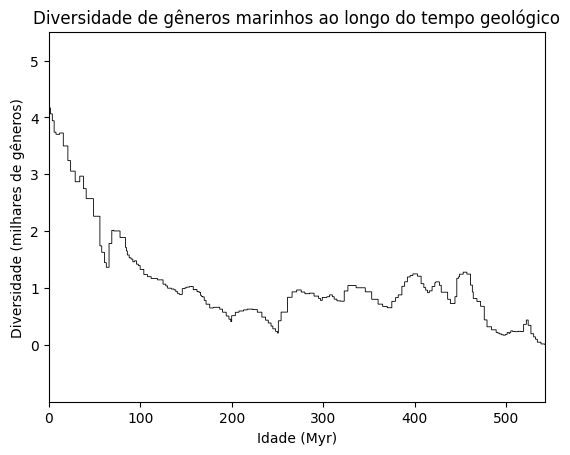

In [54]:
# Eixo y: Diversidade de gêneros marinhos ao longo do tempo geológico, em milhares de gêneros.
y = df["Diversity"] / 1000

# Plotando a série temporal 
fig, ax = plt.subplots()
plt.title("Diversidade de gêneros marinhos ao longo do tempo geológico")
ax.stairs(y, linewidth=0.6, color="black")
ax.set(xlim=(0, 542), xticks=np.arange(0, 542, 100),
       ylim=(-1, 5.5), yticks=np.arange(0, 6),
       xlabel="Idade (Myr)", ylabel="Diversidade (milhares de gêneros)")

# Salvando e exibindo o gráfico
plt.savefig(str(RESULTS_PATH / "etapa1_diversidade_generos.png"), dpi=300, bbox_inches="tight")
plt.show()

### Análise de Tendências 
Observamos uma tendência de longo prazo descrescente, principalmente nos primeiros 80 milhões de anos, indicando uma redução acentuada na diversidade após um possível pico inicial. Ao longo da série é possível identificar picos (máximos locais) de diversidade notadamente por volta de: 
- ~80 Myr, com us salto acentuado
- ~280-450 Myr, onde há oscilações repetidas e relativamente marcadas
- ~500 Myr, um pequeno pico seguido por queda

Da mesma forma, vales (mínimos locais) estão presentes:
- ~100-250 Myr, onde a diversidade parece estabilizar em valores mais baixos
- ~450-500 Myr, sugreindo uma possível extinção significativa

Essas variações indicam que, além da tendência geral descrescente, há flutuações cílicas que podem conter padrões periódicos, o que iremos investigas nas próximas etapas a partir de análise espectral.

## Etapa 2 - Remoção de Tendências
### Ajuste polinomial
Para isolar as flutuações periódicas da diversidade ao longo do tempo e eliminar as variações que se devem as tendências de longo prazo ajustamos um polinômio de terceira ordem aos dados. Isso é feito com ajuda da biblioteca numpy. 




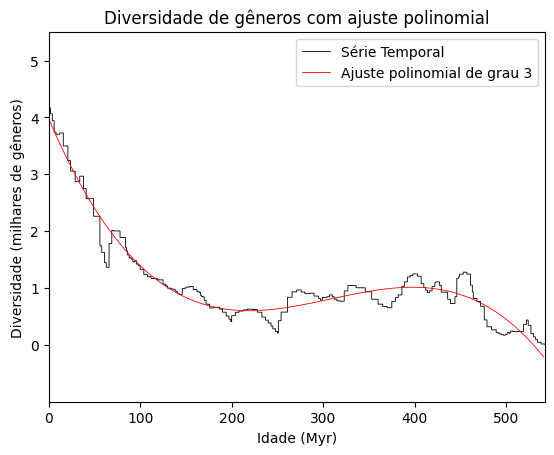

In [61]:
def detrend(y):
       # Ajuste polinomial de grau 3
       coeficients = np.polyfit(np.arange(len(y)), y, 3)
       polynomial = np.poly1d(coeficients)
       return polynomial


# Eixo x: Idade geológica em milhões de anos (Myr).
x = df["TimeBin"]
# Eixo y: Diversidade de gêneros marinhos ao longo do tempo geológico, em milhares de gêneros.
y = df["Diversity"] / 1000

# Ajuste da série temporal com polinômio de grau 3
polynomial = detrend(y)

# Plotando a série temporal e o ajuste polinomial
fig, ax = plt.subplots()
ax.stairs(y, linewidth=0.6, color="black")
ax.set(xlim=(0, 542), xticks=np.arange(0, 542, 100),
       ylim=(-1, 5.5), yticks=np.arange(0, 6),
       xlabel="Idade (Myr)", ylabel="Diversidade (milhares de gêneros)",
       title="Diversidade de gêneros com ajuste polinomial")

ax.plot(x, polynomial(x), color="red", linewidth=0.6)
ax.legend(["Série Temporal", "Ajuste polinomial de grau 3"], loc="upper right")

# Salvando e exibindo o gráfico
plt.savefig(str(RESULTS_PATH / "etapa2_remocao_tendencia.png"), dpi=300, bbox_inches="tight")
plt.show()

### Obtenção dos resíduos
Subtraindo a tendência (polinômio ajustado) dos dados originais, obtemos uma série composta pelas variações em torno da tendência, que chamamos de resíduos. Esses resíduos são mais apropiados para análise espectral, pois removem componentes que poderiam mascarar os padrões cíclicos que estamos querendo detectar.  

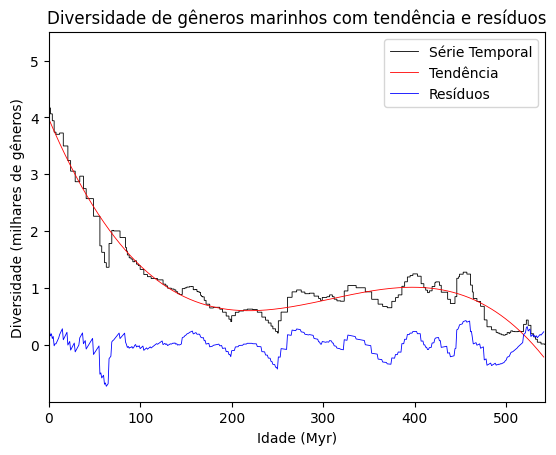

In [56]:
# Cálculo dos resíduos
residuals = y - polynomial(x)

# Plotando a série original, a linha de tendência e os resíduos
fig, ax = plt.subplots()
ax.stairs(y, linewidth=0.6, color="black")
ax.set(xlim=(0, 542), xticks=np.arange(0, 542, 100),
       ylim=(-1, 5.5), yticks=np.arange(0, 6),
       xlabel="Idade (Myr)", ylabel="Diversidade (milhares de gêneros)", 
       title = "Diversidade de gêneros marinhos com tendência e resíduos")

ax.plot(x, polynomial(x), color="red", linewidth=0.6)
ax.plot(x, residuals, color="blue", linewidth=0.6)
ax.legend(["Série Temporal", "Tendência", "Resíduos"], loc="upper right")

# Salvando e exibindo o gráfico
plt.savefig(str(RESULTS_PATH / "etapa2_residuos.png"), dpi=300, bbox_inches="tight")
plt.show()

## Etapa 3 - Análise Espectral
### Aplicação da Transformada de Fourier
Agora podemos aplicar a transformada de Fourrier à série sem tendências (resíduos) para decompô-la em diferentes frequências e permitir uma análise das oscilações periódicas presentes nos dados. Usamos a biblioteca scipy para obter a transformada de Fourrier. 

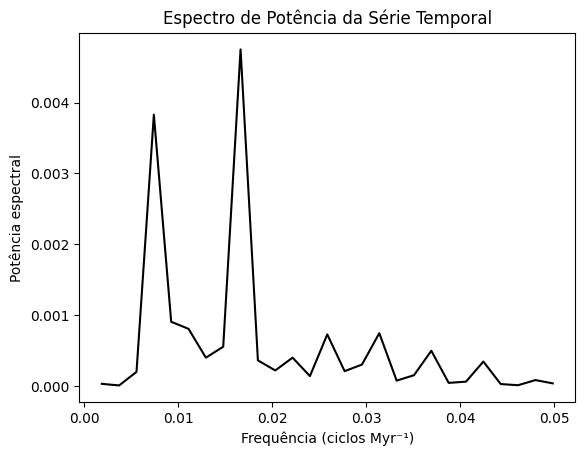

In [57]:
# Cálculo do espectro de potência usando a transformada de Fourier
def calcular_espectro(series):
    # Eixo x: Frequências em ciclos por Myr
    freqs = fftfreq(len(series))
    # Eixo y: Potência espectral normalizada
    fft_vals = fft(series)
    potencia = (np.abs(fft_vals) / len(series))**2

    # Filtramos as frequências entre 0 e 0.05 ciclos por Myr 
    # (correspondendo a períodos maiores que 20 Myr)
    mask = (freqs > 0) & (freqs < 0.05)
    return freqs[mask], potencia[mask]

# Aplicando a transformada de Fourier aos resíduos
freqs, pots = calcular_espectro(residuals)

# Plotando o espectro de potência
fig, ax = plt.subplots()
ax.plot(freqs, pots, color='black')
ax.set(xlabel='Frequência (ciclos Myr⁻¹)', ylabel=('Potência espectral'),
       title='Espectro de Potência da Série Temporal')

# Salvando e exibindo o gráfico
plt.savefig(str(RESULTS_PATH / "etapa3_espectro_potencia.png"), dpi=300, bbox_inches="tight")
plt.show()


### Refinamento do Espectro
Ao analisar o espectro de potência acima, observamos que o gráfico resultante apresentava uma resolução limitada, dificultando a visualização precisa dos picos de potência e a identificação clara das frequências dominantes. 

Para melhorar a resolução do espectro, aplicamos padding (adição de zeros) à série antes da transformada de Fourier, facilitando a identificação dos picos e frequências dominantes. Isso também foi feito por meio da biblioteca numpy.

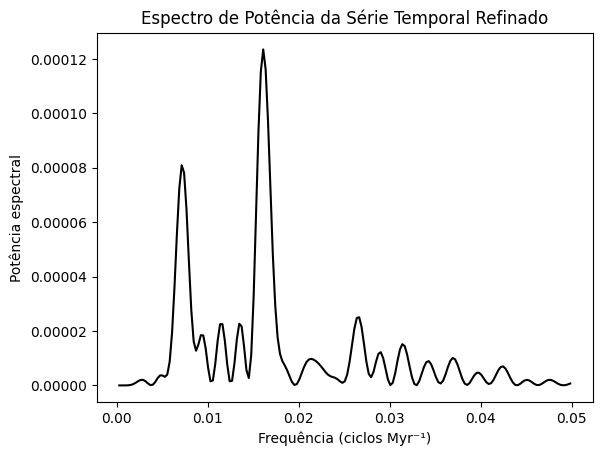

In [58]:
# Cálculo do espectro de potência com padding para maior resolução
def calcular_espectro_refinado(series, pad=1):
    N = len(series)
    N_pad = pad * N
    series_padded = np.pad(series, (0, N_pad - N), 'constant')
    return calcular_espectro(series_padded)

# Aplicando a transformada de Fourier aos resíduos
freqs_ref, pots_ref = calcular_espectro_refinado(residuals, pad=7)

# Plotando o espectro de potência refinado
fig, ax = plt.subplots()
ax.plot(freqs_ref, pots_ref, color='black')
ax.set(xlabel='Frequência (ciclos Myr⁻¹)', ylabel=('Potência espectral'),
       title='Espectro de Potência da Série Temporal Refinado')

# Salvando e exibindo o gráfico
plt.savefig(str(RESULTS_PATH / "etapa3_espectro_potencia_refinado.png"), dpi=300, bbox_inches="tight")
plt.show()

### Identificação dos Picos Relevantes
Agora vamos analisar o espectro de potência e identificar os picos relevantes, utilizando a biblioteca scipy. Começamos definindo um threshold ded 10%, ou seja, vamos identificar os picos que apresentam potência maior que 10% da potência do maior pico.

Número de picos identificados (threshold de 10%): 7
Período: 140.52 Myr - Potência: 0.000081
Período: 108.40 Myr - Potência: 0.000018
Período: 86.23 Myr - Potência: 0.000023
Período: 74.39 Myr - Potência: 0.000023
Período: 62.20 Myr - Potência: 0.000123
Período: 37.56 Myr - Potência: 0.000025
Período: 31.88 Myr - Potência: 0.000015


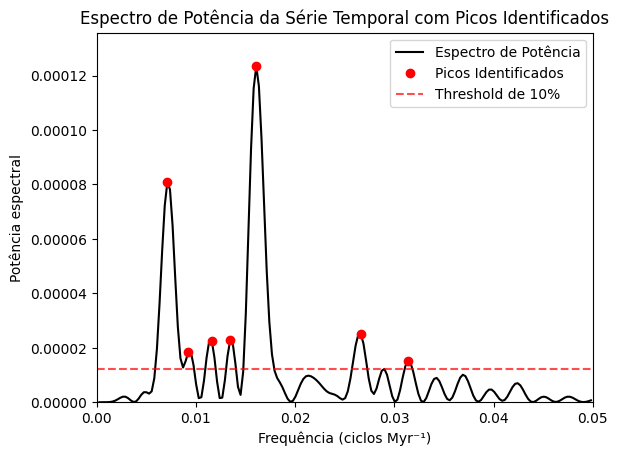

In [59]:
def identificar_picos(freqs, pots, threshold_frac=0.1):
    # Identificando picos no espectro de potência
    threshold = np.max(pots) * threshold_frac
    min_distance = len(freqs) // 50  # distância mínima entre picos
    picos, properties = find_peaks(pots, height=threshold, distance=min_distance)

    # Exibindo os picos identificados
    print(f"Número de picos identificados (threshold de 10%): {len(picos)}")
    for i in picos:
        periodo = 1/freqs_ref[i]
        potencia = pots_ref[i]
        print(f"Período: {periodo:.2f} Myr - Potência: {potencia:.6f}")

    return picos, properties, threshold

# Uso da função para identificar picos
picos, properties, threshold = identificar_picos(freqs_ref, pots_ref, threshold_frac=0.1)


# Plot para visualizar os picos identificados
fig, ax = plt.subplots()
ax.plot(freqs_ref, pots_ref, label='Espectro de Potência', color='black')
ax.plot(freqs_ref[picos], pots_ref[picos], 'ro', label='Picos Identificados')
ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label='Threshold de 10%') 
ax.set(xlim=(0, 0.05), ylim=(0, np.max(pots_ref) * 1.1),
       xticks=np.arange(0, 0.06, 0.01),
       yticks=np.arange(0, np.max(pots_ref) * 1.1, 0.00002),
       xlabel='Frequência (ciclos Myr⁻¹)', ylabel='Potência espectral',
       title='Espectro de Potência da Série Temporal com Picos Identificados')
ax.legend()

# Salvando e exibindo o gráfico
plt.savefig(str(RESULTS_PATH / "etapa3_espectro_com_picos_threshold_10.png"), dpi=300, bbox_inches="tight")
plt.show()

O threshold de 10% mostrou-se muito sensível, identificando um número muito alto de picos. Por isso, decidimos aumentar para 25%. 

Número de picos identificados (threshold de 25%): 2
Período: 140.52 Myr - Potência: 0.000081
Período: 62.20 Myr - Potência: 0.000123


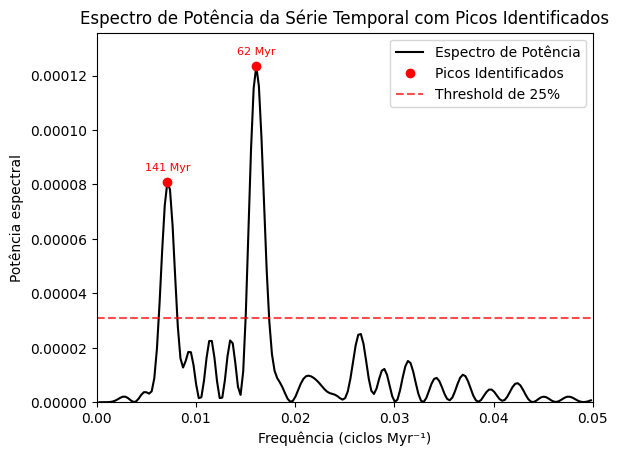

In [60]:
def identificar_picos(freqs, pots, threshold_frac=0.1):
    # Identificando picos no espectro de potência
    threshold = np.max(pots) * threshold_frac
    min_distance = len(freqs) // 50  # distância mínima entre picos
    picos, properties = find_peaks(pots, height=threshold, distance=min_distance)

    # Exibindo os picos identificados
    print(f"Número de picos identificados (threshold de {int(threshold_frac*100)}%): {len(picos)}")
    for i in picos:
        freq = freqs[i]
        periodo = 1 / freq
        potencia = pots[i]
        print(f"Período: {periodo:.2f} Myr - Potência: {potencia:.6f}")

    return picos, properties, threshold

# Uso da função para identificar picos
picos, properties, threshold = identificar_picos(freqs_ref, pots_ref, threshold_frac=0.25)

# Plot para visualizar os picos identificados
fig, ax = plt.subplots()
ax.plot(freqs_ref, pots_ref, label='Espectro de Potência', color='black')
ax.plot(freqs_ref[picos], pots_ref[picos], 'ro', label='Picos Identificados')
ax.axhline(y=threshold, color='r', linestyle='--', alpha=0.7, label='Threshold de 25%') 

# Adicionando o valor da frequência e do período ao lado de cada pico identificado
for i in picos:
    freq = freqs_ref[i]
    periodo = 1 / freq
    # Período (acima da bolinha)
    ax.annotate(f'{periodo:.0f} Myr',
                (freq, pots_ref[i]),
                textcoords="offset points",
                xytext=(0, 8), ha='center', fontsize=8, color='red')

ax.set(xlim=(0, 0.05), ylim=(0, np.max(pots_ref) * 1.1),
       xticks=np.arange(0, 0.06, 0.01),
       yticks=np.arange(0, np.max(pots_ref) * 1.1, 0.00002),
       xlabel='Frequência (ciclos Myr⁻¹)', ylabel='Potência espectral',
       title='Espectro de Potência da Série Temporal com Picos Identificados')
ax.legend()

# Salvando e exibindo o gráfico
plt.savefig(str(RESULTS_PATH / "etapa3_espectro_com_picos_threshold_25.png"), dpi=300, bbox_inches="tight")
plt.show()

Notamos a presença de dois picos relevantes em 62 e 141 Myr. 

## Etapa 4 - Construção de Modelos Nulos
Para testar a significância dos picos identificados, implementaremos simulações de Monte Carlo para gerar séries temporais aleatórias que preservem certas característica estatísticas dos dados originais. Utilizaremos dois modelos: R e W. 
### Modelo R
Nesse modelo embaralhamos os incrementos da série, simulando um passeio aleatório. 

Gerando 30000 simulações do Modelo R...
Processando simulação 5000/30000
Processando simulação 10000/30000
Processando simulação 15000/30000
Processando simulação 20000/30000
Processando simulação 25000/30000
Processando simulação 30000/30000


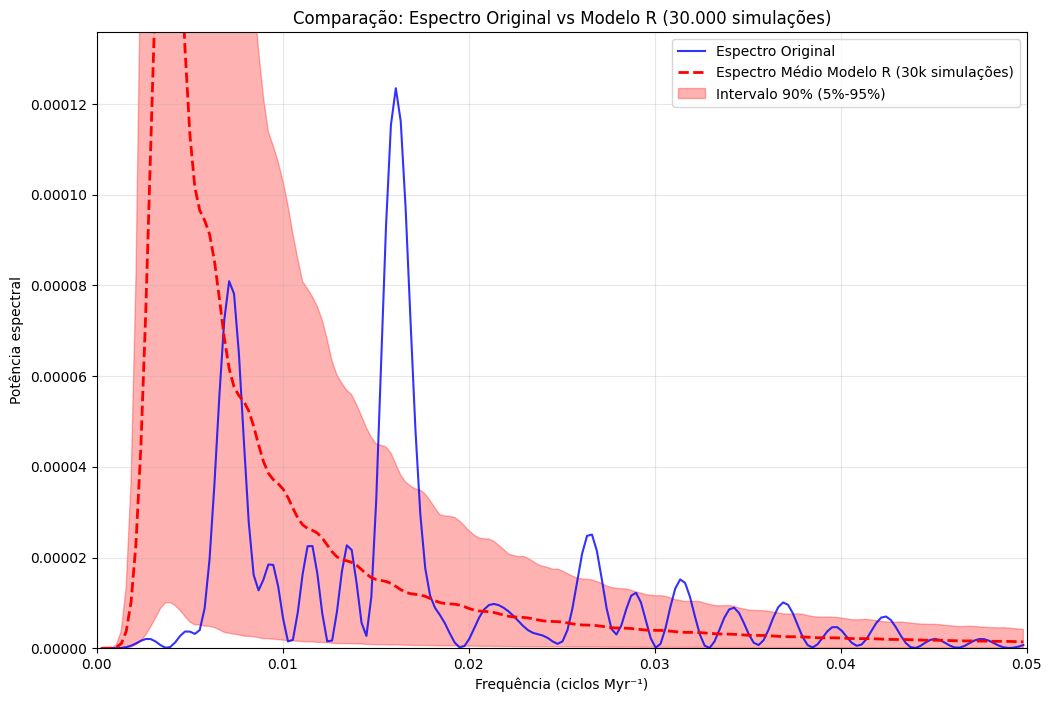

Processamento concluído! Média de 30000 espectros calculada.


In [63]:
def modelo_r_com_espectro(series, n_simulacoes=30000):
    """
    Gera simulações do modelo R, aplica detrend e calcula FFT para cada uma.
    Retorna a média dos espectros de potência.
    """
    print(f"Gerando {n_simulacoes} simulações do Modelo R...")
    
    # Calcular incrementos da série original
    incrementos = np.diff(series)
    
    # Lista para armazenar todos os espectros de potência
    todos_espectros = []
    
    for i in range(n_simulacoes):
        if (i + 1) % 5000 == 0:  # Progress indicator
            print(f"Processando simulação {i + 1}/{n_simulacoes}")
        
        # Embaralhar os incrementos
        incrementos_embaralhados = np.random.permutation(incrementos)
        
        # Reconstruir a série a partir dos incrementos embaralhados
        serie_simulada = np.zeros(len(series))
        serie_simulada[0] = series[0]  # Valor inicial igual ao original
        
        for j in range(1, len(series)):
            serie_simulada[j] = serie_simulada[j-1] + incrementos_embaralhados[j-1]
        
        # Aplicar detrend à série simulada
        polynomial_sim = detrend(serie_simulada)
        residuals_sim = serie_simulada - polynomial_sim(np.arange(len(serie_simulada)))
        
        # Calcular espectro de potência refinado
        freqs_sim, pots_sim = calcular_espectro_refinado(residuals_sim, pad=7)
        
        todos_espectros.append(pots_sim)
    
    # Converter para array numpy e calcular a média
    todos_espectros = np.array(todos_espectros)
    espectro_medio = np.mean(todos_espectros, axis=0)
    
    # As frequências são as mesmas para todas as simulações
    freqs_ref, _ = calcular_espectro_refinado(series, pad=7)
    
    return freqs_ref, espectro_medio, todos_espectros

# Aplicando o modelo R com cálculo de espectro
freqs_r, espectro_medio_r, todos_espectros_r = modelo_r_com_espectro(residuals, n_simulacoes=30000)

# Plotando o espectro médio do modelo R comparado com o espectro original
fig, ax = plt.subplots(figsize=(12, 8))

# Espectro original
ax.plot(freqs_ref, pots_ref, 'b-', linewidth=1.5, label='Espectro Original', alpha=0.8)

# Espectro médio do modelo R
ax.plot(freqs_r, espectro_medio_r, 'r--', linewidth=2, label='Espectro Médio Modelo R (30k simulações)')

# Adicionando intervalo de confiança (percentis 5% e 95%)
percentil_5 = np.percentile(todos_espectros_r, 5, axis=0)
percentil_95 = np.percentile(todos_espectros_r, 95, axis=0)
ax.fill_between(freqs_r, percentil_5, percentil_95, alpha=0.3, color='red', 
                label='Intervalo 90% (5%-95%)')

ax.set(xlim=(0, 0.05), ylim=(0, np.max(pots_ref) * 1.1),
       xlabel='Frequência (ciclos Myr⁻¹)', ylabel='Potência espectral',
       title='Comparação: Espectro Original vs Modelo R (30.000 simulações)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.savefig(str(RESULTS_PATH / "etapa4_modelo_r_espectro_medio.png"), dpi=300, bbox_inches="tight")
plt.show()

print(f"Processamento concluído! Média de {len(todos_espectros_r)} espectros calculada.")

### Modelo W
Nesse modelo embaralhamos os blocos da série preservando autocorrelações locais.

In [ ]:
def modelo_w(series, tamanho_bloco=10, n_simulacoes=30000):
    series_simuladas = []
    n_pontos = len(series)
    
    for _ in range(n_simulacoes):
        # Dividir a série em blocos
        blocos = []
        for i in range(0, n_pontos, tamanho_bloco):
            fim = min(i + tamanho_bloco, n_pontos)
            blocos.append(series[i:fim])
        
        # Embaralhar os blocos
        blocos_embaralhados = np.random.permutation(blocos)
        
        # Reconstruir a série concatenando os blocos embaralhados
        serie_simulada = np.concatenate(blocos_embaralhados)
        
        # Ajustar para o tamanho original (caso o último bloco seja menor)
        serie_simulada = serie_simulada[:n_pontos]
        
        series_simuladas.append(serie_simulada)
    
    return series_simuladas


simulacoes

In [ ]:
def calcular_espectros_nulos(series_simuladas):
    """
    Calcula os espectros de potência para todas as séries simuladas.
    
    Args:
        series_simuladas: lista de séries temporais simuladas
    
    Returns:
        lista de espectros de potência (freqs, pots) para cada simulação
    """
    espectros = []
    
    for serie in series_simuladas:
        freqs, pots = calcular_espectro_refinado(serie, pad=7)
        espectros.append((freqs, pots))
    
    return espectros

# Executando as simulações
print("Gerando modelos nulos...")
print("Modelo R: Embaralhando incrementos...")
series_modelo_r = modelo_r(residuals, n_simulacoes=1000)

print("Modelo W: Embaralhando blocos...")
series_modelo_w = modelo_w(residuals, tamanho_bloco=10, n_simulacoes=1000)

# Calculando espectros para os modelos nulos
print("Calculando espectros de potência para Modelo R...")
espectros_r = calcular_espectros_nulos(series_modelo_r)

print("Calculando espectros de potência para Modelo W...")
espectros_w = calcular_espectros_nulos(series_modelo_w)

print("Modelos nulos gerados com sucesso!")